In [1]:
AUGMENT = True
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 10

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.utils.data as data

from tqdm import tqdm
import numpy as np
import random
import os

from torchvision.transforms import ToTensor
from torchvision import datasets, transforms


In [3]:
import sys

sys.path.append(os.path.abspath('../'))
from utils import Metrics, plot_confusion_matrix
from training_scripts.vit_model import ViTForImageClassification
from training_scripts.vit_helpers import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = ViTForImageClassification(num_labels = NUM_CLASSES)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()


In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [7]:
train_loader = pytorch_data_loader(path = "data/train", batch_size=BATCH_SIZE, augment=AUGMENT)
val_loader = pytorch_data_loader(path = "data/val", batch_size=BATCH_SIZE, augment=False)
test_loader = pytorch_data_loader(path = "data/test", batch_size=BATCH_SIZE, augment=False)

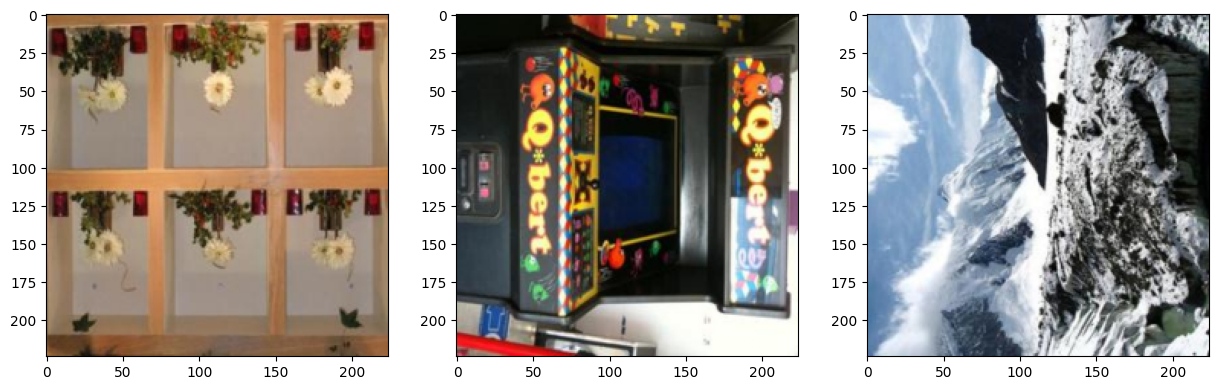

In [ ]:
"""dataiter = iter(train_loader)
images, labels = next(dataiter)

if images.shape[0] > 3:
    indices = torch.randperm(images.shape[0])[:3]
    images_to_show = images[indices]
else:
    images_to_show = images

show_images(images_to_show)"""


In [18]:
if AUGMENT:
    file_path = os.path.join("checkpoints","ViT","augmented")
else:
    file_path = os.path.join("checkpoints","ViT","base")

In [19]:
EARLY_STOPPING = True

## VIT Trainer

In [ ]:
from tqdm import tqdm

val_accuracy = 0
best_val_accuracy  = 0
count = 0

history = {"train_accuracy": [], "train_loss": [], "val_accuracy": [], "val_loss": []}

for epoch in range(EPOCHS):
    model.train()
    running_loss, train_correct, train_total = 0.0, 0, 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{EPOCHS}')
    
    for step, (x, y) in progress_bar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x, labels=y) 
        loss = outputs.loss

        if loss is not None:
            loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        output = outputs.logits.argmax(dim=1)
        train_correct += (output == y).sum().item()
        train_total += y.size(0)
        
        progress_bar.set_postfix({'train_loss': f'{running_loss / (step + 1):.4f}', 'train_acc': f'{train_correct / train_total:.4f}'})

    model.eval()
    with torch.no_grad():
        valid_loss, valid_correct, valid_total = 0.0, 0, 0
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x, labels=y)
            valid_output = outputs.logits.argmax(dim=1)
            valid_loss += outputs.loss.item()
            valid_correct += (valid_output == y).sum().item()
            valid_total += y.size(0)

        val_accuracy = valid_correct / valid_total
        valid_loss /= len(val_loader)
        print(f'Validation Loss: {valid_loss:.4f} | Accuracy: {val_accuracy:.4f}')

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_model(path=os.path.join(file_path,f'{epoch+1}_val_acc{val_accuracy:.4f}.pth'), model=model, epoch=epoch, optimizer=optimizer)
            print("Saved Best Model")
            count = 0
        else:
            if EARLY_STOPPING:
                count += 1
            if count == 5:
                print("Early Stopping Implemented")
                break

        progress_bar.set_description(f'Epoch {epoch+1}/{EPOCHS} - Val Accuracy: {val_accuracy:.4f}')
    
    history["train_accuracy"].append(train_correct / train_total)
    history["train_loss"].append(running_loss / (step + 1))
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(valid_loss)
    
history_path = os.path.join(file_path, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f)
        
save_model(path=f'checkpoints/ViT/{epoch+1}_val_acc{val_accuracy:.4f}.pth', model=model, epoch=epoch, optimizer=optimizer)

## Testing Data

In [5]:
vit_model = load_model(path = "ViT/37_val_acc0.7911.pth", model = ViTForImageClassification(10))

In [9]:
def predict_testing(testing_data, model, device):
    model.eval()
    predictions = []
    y_values = []
    with torch.no_grad():
        valid_loss, valid_correct, valid_total = 0.0, 0, 0
        for x, y in tqdm(testing_data):
            x, y = x.to(device), y.to(device)
            outputs = model(x, y)
            valid_output = outputs.logits.argmax(dim=1)
            valid_loss += outputs.loss
            valid_correct += (valid_output == y).sum().item()
            valid_total += y.size(0)
            
            predictions.extend(valid_output)
            y_values.extend(y)

        val_accuracy = valid_correct / valid_total
        valid_loss /= len(testing_data)  # Normalize validation loss
        print(f'Validation Loss: {valid_loss:.4f} | Accuracy: {val_accuracy:.4f}')
        return predictions, y_values

In [10]:
test_predictions, test_classes = predict_testing(testing_data = test_loader, model = vit_model, device=device)

100%|██████████| 338/338 [17:58<00:00,  3.19s/it]

Validation Loss: 0.5569 | Accuracy: 0.7987


In [14]:
#test_predictions = np.argmax(test_predictions, axis = 1)

results = Metrics(title = "EuroSAT")
results.run(test_classes, test_predictions, method_name = "ResNet50")
results.plot()

In [19]:
classes = {'barn': 0,
        'downtown': 1,
        'forest': 2,
        'hayfield': 3,
        'highway': 4,
        'oilrig': 5,
        'residential_neighborhood': 6,
        'volcano': 7,
        'wave': 8,
        'windmill': 9}

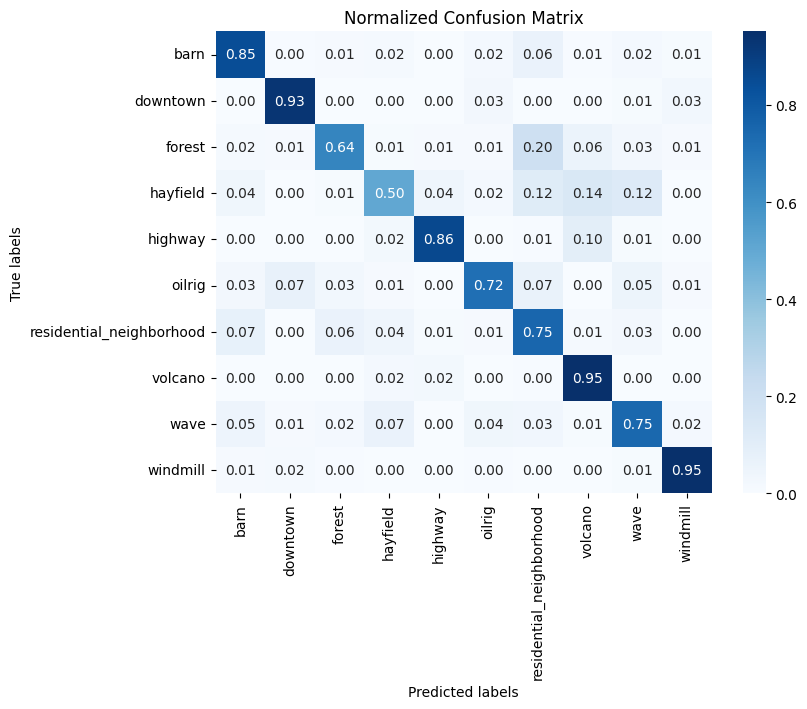

In [20]:
plot_confusion_matrix(test_classes, test_predictions, classes = classes.keys())